In [1]:
print(' ~ ~ ~ ~ ~ ~ ~ ~ OM SHRI GANESHAAYA NAMAHA ~ ~ ~ ~ ~ ~ ~ ~ ')

 ~ ~ ~ ~ ~ ~ ~ ~ OM SHRI GANESHAAYA NAMAHA ~ ~ ~ ~ ~ ~ ~ ~ 


### Import required libraries

In [2]:

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

# <font color='a34668'> <b> <span style="text-decoration: underline;"> Read Data</span> </b> </font>

In [3]:
df = pd.read_csv('reviews.txt', sep='|', names=['Rating','Title','Review'], comment='#')
df.head()

,Rating,Title,Review
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc..."
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...
3,5,NEW laptop is great,so far I am loving the new look and the feel o...
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...


### <font color='d37698'> <b> Maintain a deep copy of the original dataframe for use later </b> </font>

In [4]:
df_orig = df.copy()
id(df_orig), id(df)

(2188303929936, 2188421213136)

# <font color='a33668'> <b> <span style="text-decoration: underline;">EDA</span> </b> </font>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  308 non-null    int64 
 1   Title   308 non-null    object
 2   Review  308 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.3+ KB


In [6]:
df.isna().sum(), df.isnull().sum()

(Rating    0
 Title     0
 Review    0
 dtype: int64,
 Rating    0
 Title     0
 Review    0
 dtype: int64)

In [7]:
df['Rating'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

In [8]:
df['Rating'].value_counts()

Rating
5    198
4     64
3     18
1     18
2     10
Name: count, dtype: int64

In [9]:
df.Rating.describe()

count    308.000000
mean       4.344156
std        1.114780
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64

# <font color='a34668'> <b> <span style="text-decoration: underline;">Data Pre-processing</span> </b> </font>

##### <font color='#938688'> <i> Stop words that do not reflect sentiment </i> </font>

In [10]:
# identify words that do not reflect sentiment
exclude_words = ['laptop', 'dell', 'keyboard', 'screen', 'Latitude', 'device', 'work', 'port', '7440', 
                 'The', 'I', 'It', 'This', 'laptop.','2', 'work.', 'one.', '&', '...', 'will', 'one', 'use', 'many',
                '10', '11', '13th', '14', '16gb', '32gb']

# Combine custom stopwords with default stopwords
combined_stopwords = set(STOPWORDS.union(exclude_words))

##### <font color='#938688'> <i> Lemmatization </i> </font>

In [11]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in combined_stopwords]
    return ' '.join(words)

In [12]:
df['Lemmatized_Review_Text'] = df['Review'].apply(preprocess_text)

# <font color='a34668'> <b> <span style="text-decoration: underline;">Visualization</span> </b> </font>

### <font color='d37698'> <b> Distribution of Ratings </b> </font>

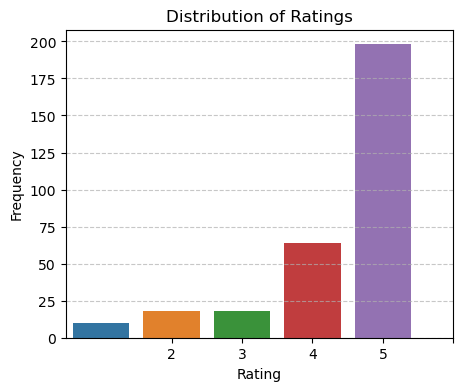

In [13]:
# Distribution of ratings using a histogram
plt.figure(figsize=(5, 4))
# plt.hist(df['Rating'], bins=5, color='skyblue', edgecolor='black', alpha=0.7)
sns.barplot(x=df['Rating'].unique(), y=df['Rating'].value_counts())
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### <font color='d37698'> <b> Distribution of Review Lenghts </b> </font>

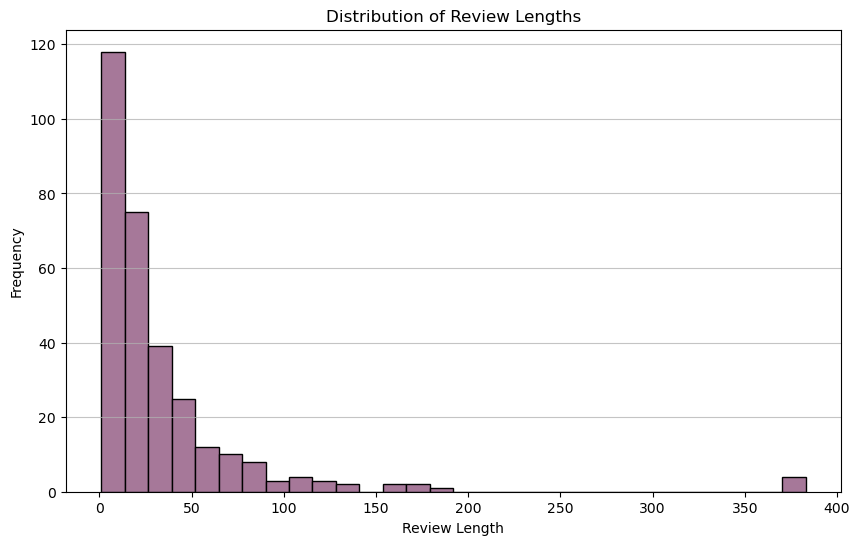

In [14]:
# Calculate the length of each review
df['Review_Length'] = df['Review'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df['Review_Length'], bins=30, color='#a67899', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.grid(axis='y', alpha=0.75)

### <font color='d37698'> <b> Distribution of Review Lenghts (excluding stop words) </b> </font>

In [15]:
df['Review_Without_Stopwords'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in combined_stopwords]))
# df['Review_without_stopwords']

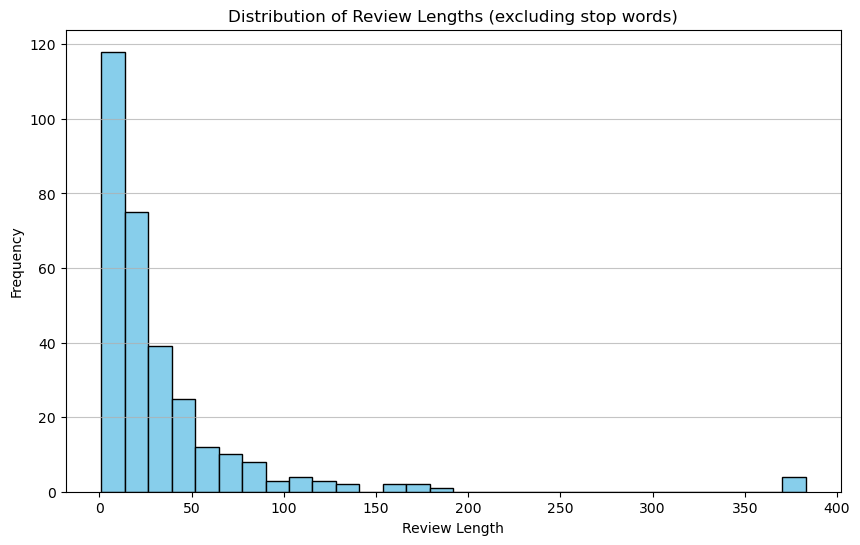

In [16]:
# Calculate the length of each review (excluding stop words)

df['Review_Length_Without_Stopwords'] = df['Review_Without_Stopwords'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths (excluding stop words)
plt.figure(figsize=(10, 6))
plt.hist(df['Review_Length'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths (excluding stop words)')
plt.grid(axis='y', alpha=0.75)

### <font color='d37698'> <b> Distributions of Top 10 Word Frequencies by Rating </b> </font>

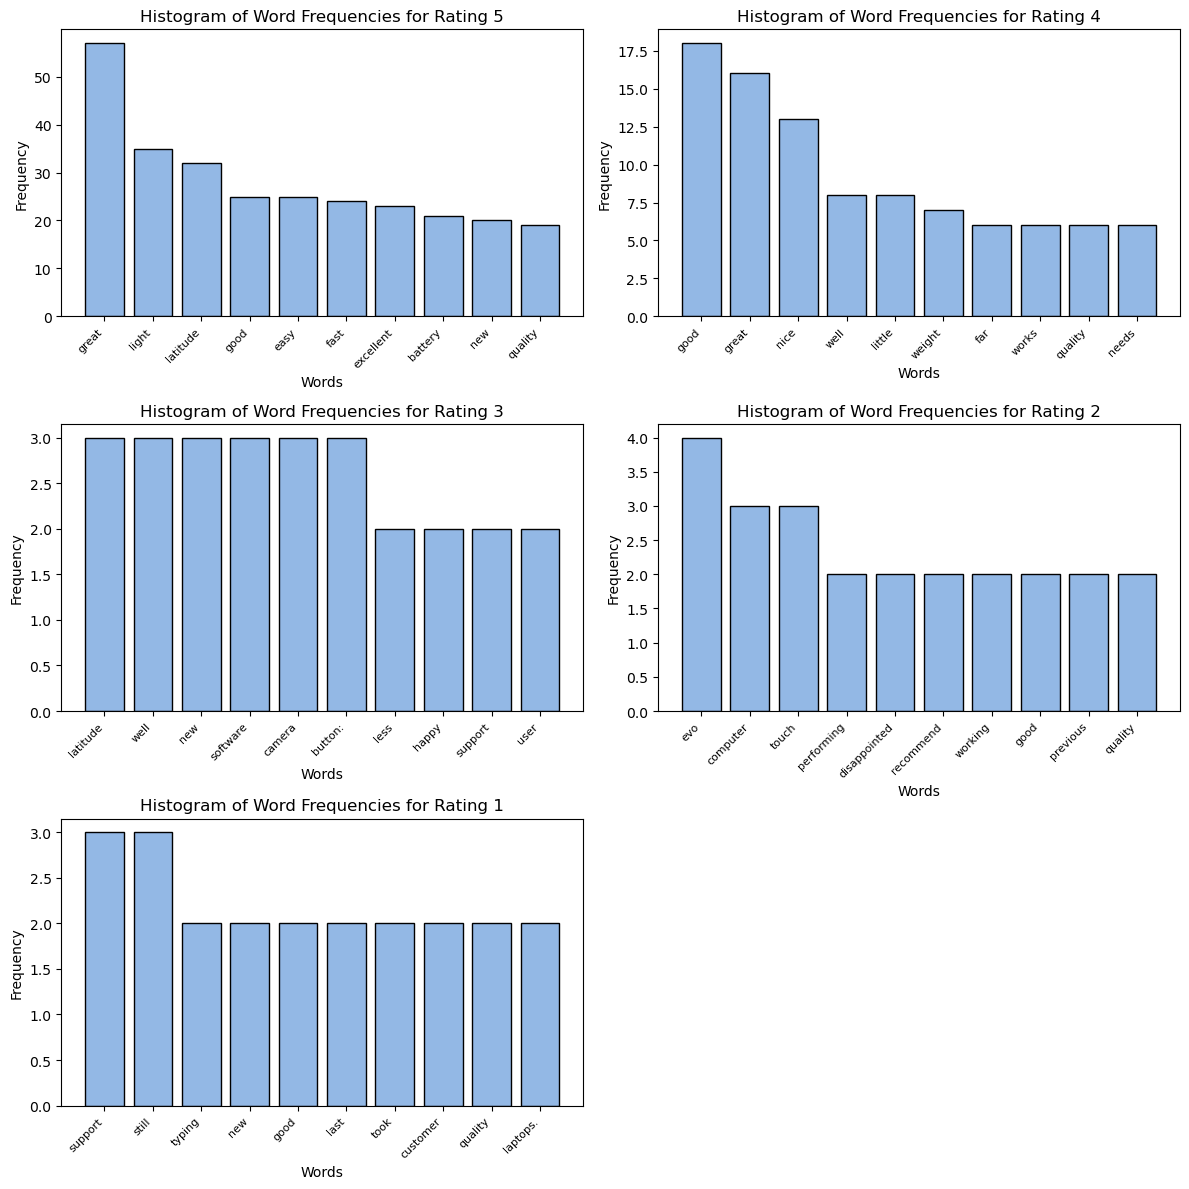

In [17]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Loop through rating values from 1 to 5
for i, n_rating in enumerate(range(5,0,-1)):
    row = i // 2
    col = i % 2
    
    words=[]
    frequencies=[]
    
    # Filter the DataFrame based on rating
    filtered_df = df[(df['Rating'] == n_rating)]
    
    # Tokenize the reviews
    tokenized_reviews = filtered_df['Review'].apply(lambda x: x.split())
    
    # Count the words
    word_counts = {}
    for review in tokenized_reviews:
        for word in review:
            word = word.lower()  # case insenstive matching
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    
    # Sort the words based on frequency
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Filter the words and remove stopwords
    filtered_words = []
    for word, count in sorted_word_counts:
        if word not in combined_stopwords:
            filtered_words.append((word, count))
    
    # Display the top N most used words
    N = 10  # Change this to the number of words you want to display
    for word, count in filtered_words[:N]:
        # print(f"{word}: {count}")
        words.append(word)
        frequencies.append(count)
        
    # Create the histogram
    ax = axs[row, col]
    ax.bar(words, frequencies, color='#93b8e5', edgecolor='black')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of Word Frequencies for Rating {n_rating}')

    ax.tick_params(axis='x', labelsize=8)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

axs[2, 1].axis('off')  # Turn off the last subplot

plt.tight_layout()
plt.show()

### <font color='d37698'> <b> Word Cloud (for the entire set of words) </b> </font>

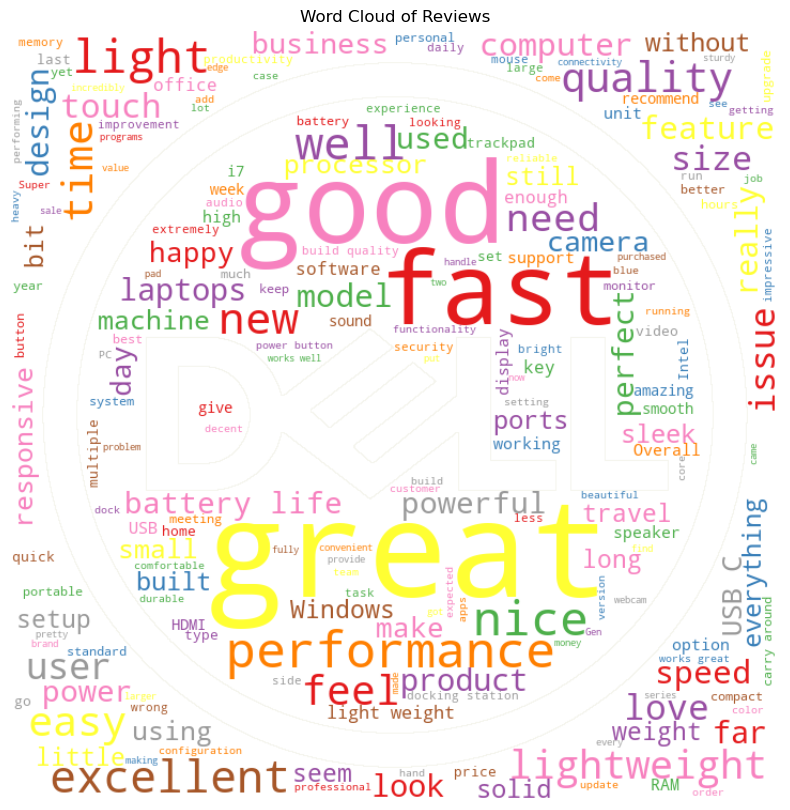

In [18]:
# Join all reviews into a single string
text = ' '.join(df['Review'].astype(str))

# Create a mask
mask = np.array(Image.open('laptop_mask.png'))

# Generate a word cloud
wordcloud = WordCloud(stopwords=combined_stopwords, width=800, height=400, background_color ='white', colormap='Set1', mask=mask, contour_color='#f5f5ee', contour_width=1)
wordcloud.generate(text)

# Display the generated word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Reviews')
plt.axis('off')
plt.show()

##### <font color='#938688'> <i> Build a corpus of words </i> </font>

In [19]:
corpus = []
r = df['Review'].str.split()
r = r.values.tolist()
corpus = [word for i in r for word in i]
corpus = " ".join(corpus)

##### <font color='#938688'> <i> Get a custom-list of postive and negative words </i> </font>

In [20]:
with open('positive-words.txt','r') as pos:
    positive_word_string = pos.read()

positive_words = positive_word_string.split()

with open('negative-words.txt', 'r') as neg:
    negative_word_string = neg.read()

negative_words = negative_word_string.split()

### <font color='d37698'> <b> Word Cloud (for postive word-set) </b> </font>

In [21]:
# this cell may take some time to execute
positive_review_words = [w for w in corpus.split() if w in positive_words]
print(f'positive_review_words length: {len(positive_review_words)}')

positive_review_words length: 2861


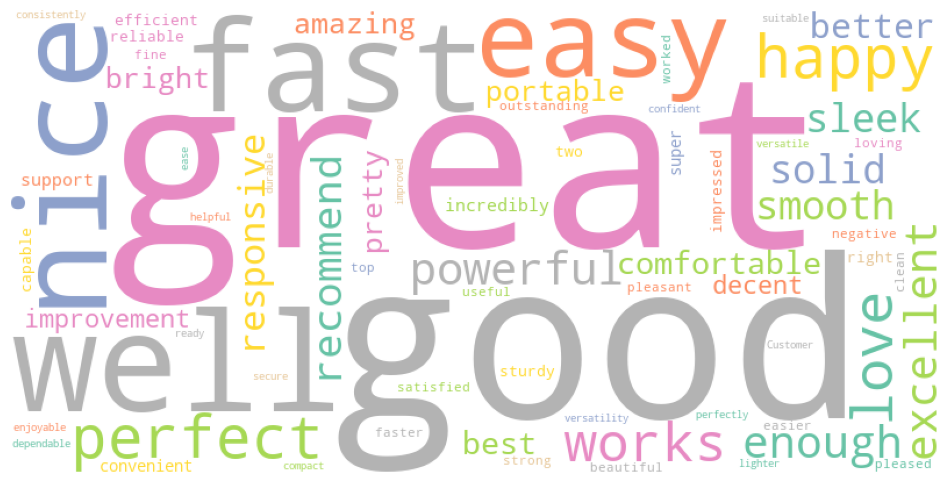

In [22]:
word_cloud = WordCloud(background_color='white',  width=800, height=400, max_words=70, colormap='Set2',stopwords=combined_stopwords).generate(' '.join(positive_review_words))

# Display the generated word cloud
plt.figure(figsize=(12, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### <font color='d37698'> <b> Word Cloud (for negative word-set) </b> </font>

In [23]:
# this cell may take some time to execute
negative_review_words = [w for w in corpus.split() if w in negative_words]
print(f'negative_review_words length: {len(negative_review_words)}')

negative_review_words length: 2320


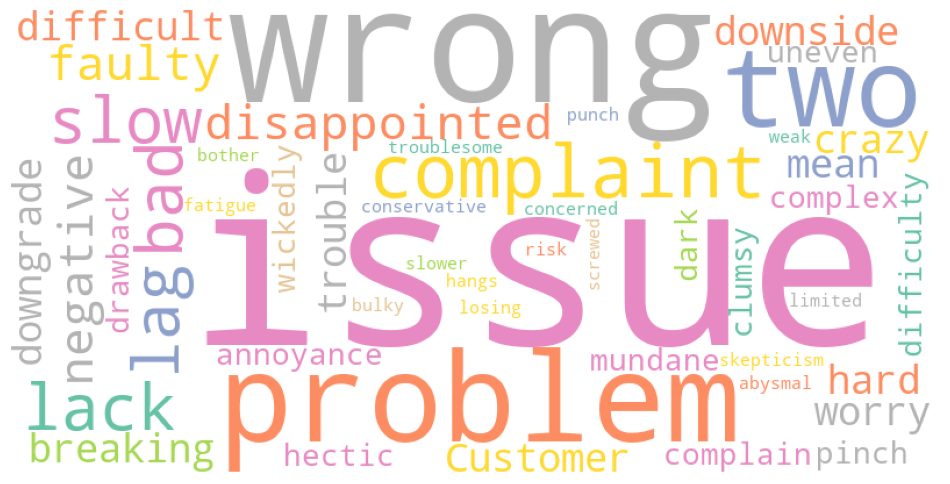

In [24]:
word_cloud = WordCloud(background_color='white',  width=800, height=400, max_words=50, colormap='Set2',stopwords=combined_stopwords).generate(' '.join(negative_review_words))

# Display the generated word cloud
plt.figure(figsize=(12, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

# <font color='a34668'> <b> <span style="text-decoration: underline;">n-gram Analysis<span></b> </font>

In [25]:
# Function returns the top 10 n-grams in the given 'corpus' and for a given value of 'n'
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

### <font color='d37698'> <b> Top 10 Bigrams </b> </font>

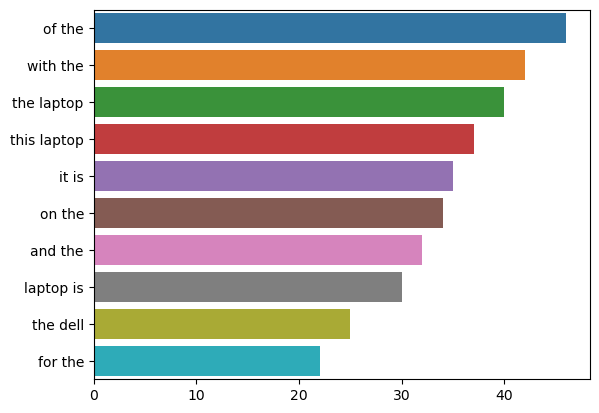

In [26]:
top_10_bigrams = get_top_ngram(df['Review'],2)[:10] 
x,y = map(list,zip(*top_10_bigrams))
sns.barplot(x=y,y=x)
plt.show()

### <font color='d37698'> <b> Top 10 Bigrams (excluding stop words) </b> </font>

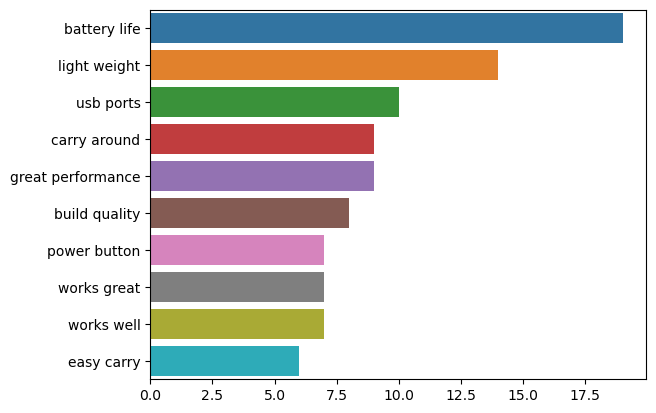

In [27]:
top_10_bigrams = get_top_ngram(df['Review_Without_Stopwords'],2)[:10] 
x,y = map(list,zip(*top_10_bigrams))
sns.barplot(x=y,y=x)
plt.show()

### <font color='d37698'> <b> Top 10 Trigrams </b> </font>

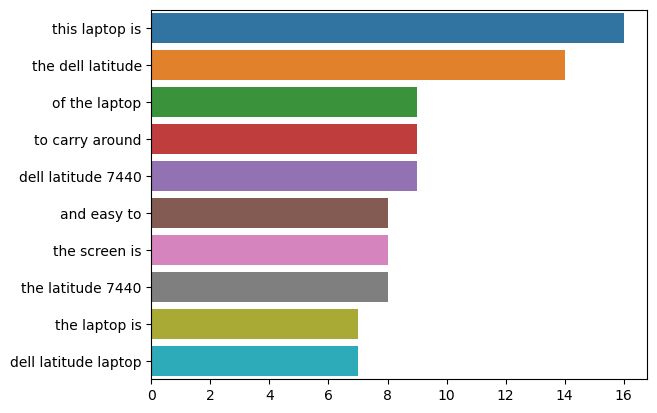

In [28]:
top_10_trigrams = get_top_ngram(df['Review'],3)[:10] 
x,y = map(list,zip(*top_10_trigrams))
sns.barplot(x=y,y=x)
plt.show()

### <font color='d37698'> <b> Top 10 Trigrams (excluding stop words) </b> </font>

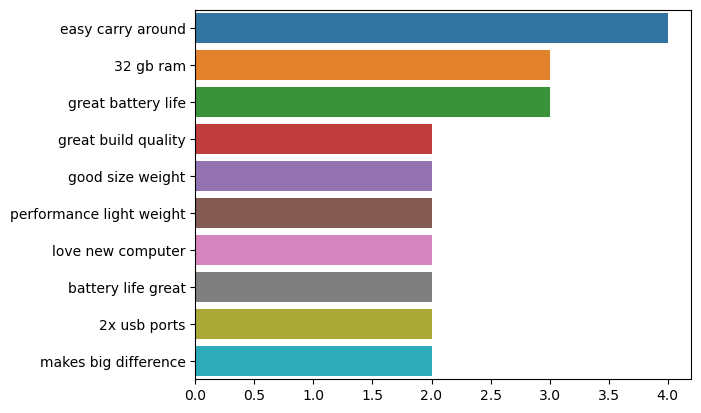

In [29]:
top_10_trigrams = get_top_ngram(df['Review_Without_Stopwords'],3)[:10] 
x,y = map(list,zip(*top_10_trigrams))
sns.barplot(x=y,y=x)
plt.show()

### <font color='d37698'> <b> Top 10 Quadgrams </b> </font>

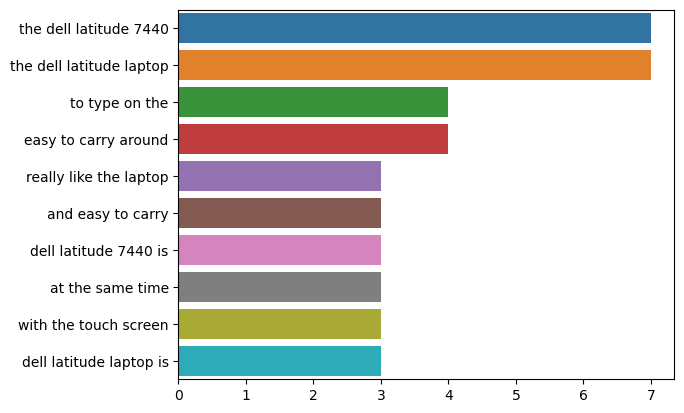

In [30]:
top_10_quadgrams = get_top_ngram(df['Review'],4)[:10] 
x,y = map(list,zip(*top_10_quadgrams))
sns.barplot(x=y,y=x)
plt.show()

### <font color='d37698'> <b> Top 10 Quadgrams (excluding stop words) </b> </font>

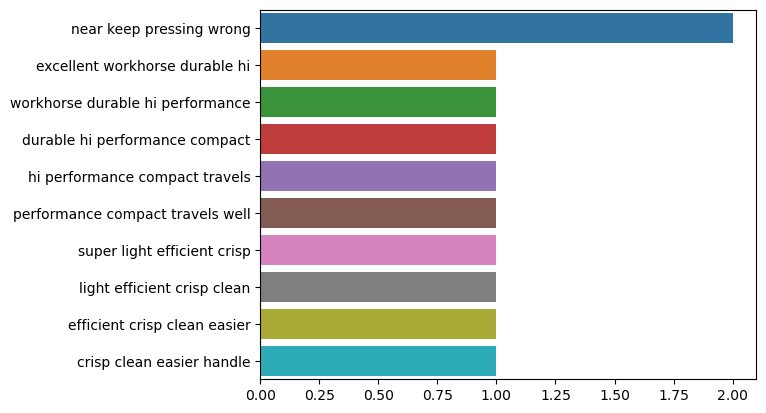

In [31]:
top_10_quadgrams = get_top_ngram(df['Review_Without_Stopwords'],4)[:10] 
x,y = map(list,zip(*top_10_quadgrams))
sns.barplot(x=y,y=x)
plt.show()

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Rating                           308 non-null    int64 
 1   Title                            308 non-null    object
 2   Review                           308 non-null    object
 3   Lemmatized_Review_Text           308 non-null    object
 4   Review_Length                    308 non-null    int64 
 5   Review_Without_Stopwords         308 non-null    object
 6   Review_Length_Without_Stopwords  308 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 17.0+ KB


In [33]:
df.head()

,Rating,Title,Review,Lemmatized_Review_Text,Review_Length,Review_Without_Stopwords,Review_Length_Without_Stopwords
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc...",excellent workhorse durable hiperformance comp...,8,"Excellent Workhorse Durable, Hi-Performance, C...",7
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!,awesome dependable,4,Awesome dependable laptop!,3
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...,super light efficient crisp clean easier handl...,20,Super light efficient Crisp clean easier handl...,11
3,5,NEW laptop is great,so far I am loving the new look and the feel o...,far loving new look feel new,15,far loving new look feel new,6
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...,great build quality excellent good option qual...,36,Great build quality excellent good options. qu...,18


# <font color='a34668'> <b> <span style="text-decoration: underline;">Sentiment Analysis</span> </b> </font>

## <font color='b35678'> <b> Textblob </b> </font>

In [37]:
def get_sentiment_assessments(txt):
    return TextBlob(txt).sentiment_assessments

def get_polarity(txt):
    return TextBlob(txt).sentiment.polarity

def get_subjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

# print ('Sentiment Assessments: ', get_sentiment_assessments('This is a pleasant place'))
# print ('Polarity: ',get_polarity('This is a pleasant place'))
# print ('Subjectivity: ',get_subjectivity('This is a pleasant place'))

In [39]:
df['tb_polarity'] = df['Review'].apply(get_polarity)

### <font color='d37698'> <b> Distribution of Polarities </b> </font>

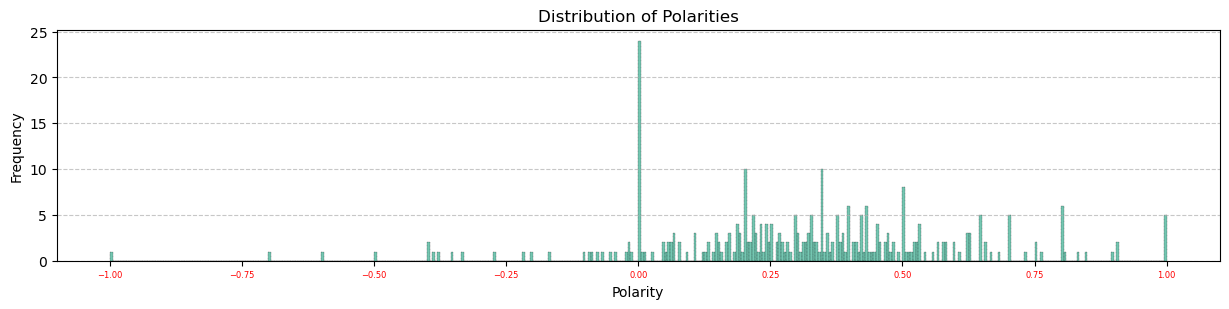

In [41]:
# Distribution of polarities using a histogram
plt.figure(figsize=(15, 3))
sns.histplot(df['tb_polarity'], bins=400, kde=False, color='#45b397', linestyle='--')
plt.title('Distribution of Polarities')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
# plt.xticks(ticks=[10], labels=['1'], fontname='Arial', fontsize=6)
plt.tick_params(axis='x', labelsize=6, labelcolor='red')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### <font color='d37698'> <b> Distribution of Sentiment </b> </font>

##### <font color='#938688'> <i> We will calculate a 'sentiment_score' as product of 'tb_polarity' and 'Rating' </i> </font>

In [42]:
df['sentiment_score_tb'] = df['tb_polarity'] * df['Rating']

##### <font color='#938688'> <i> We will assign a 'sentiment' category based on the calculated 'sentiment_score' </i> </font>
<font color='#938688' face='Courier New'>
<ul> 
    <li>-5.00 to -3.00 => V. Negative</li>
    <li>-3.00 to -0.75 => Negative</li>
    <li>-0.75 to 0.75 => Neutral</li>
    <li>0.75 to 4.25 => Positive</li>
    <li>4.25 to 5.00 => V. Positive</li>
</ul> 
</font>

In [44]:
df['sentiment_tb'] = df['sentiment_score_tb'].apply(lambda sentiment_score: 'V. Negative' 
                                                           if sentiment_score<-3 
                                                           else ( 'Negative' if sentiment_score < -0.75
                                                                 else ( 'Neutral' if sentiment_score<0.75
                                                                       else ( 'Positive' if sentiment_score< 4.25 else 'V. Positive'))))

In [45]:
df.head()

,Rating,Title,Review,Lemmatized_Review_Text,Review_Length,Review_Without_Stopwords,Review_Length_Without_Stopwords,tb_polarity,sentiment_score_tb,sentiment_tb
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc...",excellent workhorse durable hiperformance comp...,8,"Excellent Workhorse Durable, Hi-Performance, C...",7,1.000000,5.000000,V. Positive
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!,awesome dependable,4,Awesome dependable laptop!,3,1.000000,5.000000,V. Positive
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...,super light efficient crisp clean easier handl...,20,Super light efficient Crisp clean easier handl...,11,0.322000,1.610000,Positive
3,5,NEW laptop is great,so far I am loving the new look and the feel o...,far loving new look feel new,15,far loving new look feel new,6,0.243182,1.215909,Positive
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...,great build quality excellent good option qual...,36,Great build quality excellent good options. qu...,18,0.626250,3.131250,Positive


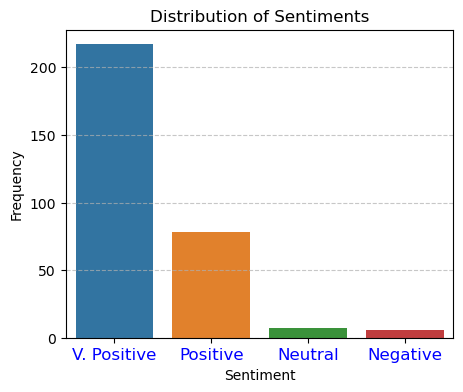

In [46]:
plt.figure(figsize=(5, 4))
freq = df['sentiment_tb'].value_counts()
sns.barplot(x=df['sentiment_tb'].unique(), y=freq)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.tick_params(axis='x', labelsize=12, labelcolor='blue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## <font color='b35678'> <b> Pre-trained Vader Lexicon </b> </font>

### <font color='d37698'> <b> Populate the compound scores for each review </b> </font>

In [47]:
sentiment_intensity_analyzer = SentimentIntensityAnalyzer()
def get_compound_score(text):
    return sentiment_intensity_analyzer.polarity_scores(text)['compound']

print('1) Sentiment for \'This is a fantastic place. Don\'t miss this for anything !\': ', 
      sentiment_intensity_analyzer.polarity_scores('This is a fantastic place. Don\'t miss this for anything !'))
print('2) Sentiment for \'This is a fantastic place. Should be on your bucket list !\': ', 
      sentiment_intensity_analyzer.polarity_scores('This is a fantastic place. Should be on your bucket list !'))
print('3) Sentiment for \'This is a fantastic place\': ', sentiment_intensity_analyzer.polarity_scores('This is a fantastic place'))
print('4) Sentiment for \'This is a pleasant place\': ', sentiment_intensity_analyzer.polarity_scores('This is a pleasant place'))
print('5) Sentiment for \'This is a pleasant place, but there are too many mosquitoes.\': ', 
      sentiment_intensity_analyzer.polarity_scores('This is a pleasant place, but there are too many mosquitoes.'))
print('6) Sentiment for \'This is a not so good a place because there are too many mosquitoes.\': ', 
      sentiment_intensity_analyzer.polarity_scores('This is a not so good a place because there are too many mosquitoes.'))

1) Sentiment for 'This is a fantastic place. Don't miss this for anything !':  {'neg': 0.0, 'neu': 0.567, 'pos': 0.433, 'compound': 0.6526}
2) Sentiment for 'This is a fantastic place. Should be on your bucket list !':  {'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.5983}
3) Sentiment for 'This is a fantastic place':  {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.5574}
4) Sentiment for 'This is a pleasant place':  {'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.5106}
5) Sentiment for 'This is a pleasant place, but there are too many mosquitoes.':  {'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.2846}
6) Sentiment for 'This is a not so good a place because there are too many mosquitoes.':  {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'compound': -0.464}


In [48]:
df['compound_score'] = df['Review'].apply(lambda review: get_compound_score(review))
df.head()

,Rating,Title,Review,Lemmatized_Review_Text,Review_Length,Review_Without_Stopwords,Review_Length_Without_Stopwords,tb_polarity,sentiment_score_tb,sentiment_tb,compound_score
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc...",excellent workhorse durable hiperformance comp...,8,"Excellent Workhorse Durable, Hi-Performance, C...",7,1.000000,5.000000,V. Positive,0.7003
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!,awesome dependable,4,Awesome dependable laptop!,3,1.000000,5.000000,V. Positive,0.6588
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...,super light efficient crisp clean easier handl...,20,Super light efficient Crisp clean easier handl...,11,0.322000,1.610000,Positive,0.9042
3,5,NEW laptop is great,so far I am loving the new look and the feel o...,far loving new look feel new,15,far loving new look feel new,6,0.243182,1.215909,Positive,0.6326
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...,great build quality excellent good option qual...,36,Great build quality excellent good options. qu...,18,0.626250,3.131250,Positive,0.9764


##### <font color='#938688'> <i> We will assign a 'sentiment' category based on the calculated 'compound_score' </i> </font>
<font color='#938688' face='Courier New'>
<ul> 
    <li>-1.00 to -0.60 => V. Negative</li>
    <li>-0.60 to -0.15 => Negative</li>
    <li>-0.15 to 0.15 => Neutral</li>
    <li>0.15 to 0.85 => Positive</li>
    <li>0.85 to 1.00 => V. Positive</li>
</ul> 
</font>

In [49]:
df['sentiment_vader'] = df['compound_score'].apply(lambda compound_score: 'V. Negative' 
                                                           if compound_score<-0.6 
                                                           else ( 'Negative' if compound_score < -0.15 
                                                                 else ( 'Neutral' if compound_score<0.15
                                                                       else ( 'Positive' if compound_score< 0.85 else 'V. Positive'))))
df.head()

,Rating,Title,Review,Lemmatized_Review_Text,Review_Length,Review_Without_Stopwords,Review_Length_Without_Stopwords,tb_polarity,sentiment_score_tb,sentiment_tb,compound_score,sentiment_vader
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc...",excellent workhorse durable hiperformance comp...,8,"Excellent Workhorse Durable, Hi-Performance, C...",7,1.000000,5.000000,V. Positive,0.7003,Positive
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!,awesome dependable,4,Awesome dependable laptop!,3,1.000000,5.000000,V. Positive,0.6588,Positive
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...,super light efficient crisp clean easier handl...,20,Super light efficient Crisp clean easier handl...,11,0.322000,1.610000,Positive,0.9042,V. Positive
3,5,NEW laptop is great,so far I am loving the new look and the feel o...,far loving new look feel new,15,far loving new look feel new,6,0.243182,1.215909,Positive,0.6326,Positive
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...,great build quality excellent good option qual...,36,Great build quality excellent good options. qu...,18,0.626250,3.131250,Positive,0.9764,V. Positive


### <font color='d37698'> <b> Showing sentiment value counts as percentage of total </b> </font>

In [50]:
df['sentiment_vader'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

sentiment_vader
Positive       53.2%
V. Positive    25.6%
Neutral        11.7%
Negative        7.1%
V. Negative     2.3%
Name: proportion, dtype: object

### <font color='d37698'> <b> Plot compound score distribution </b> </font>

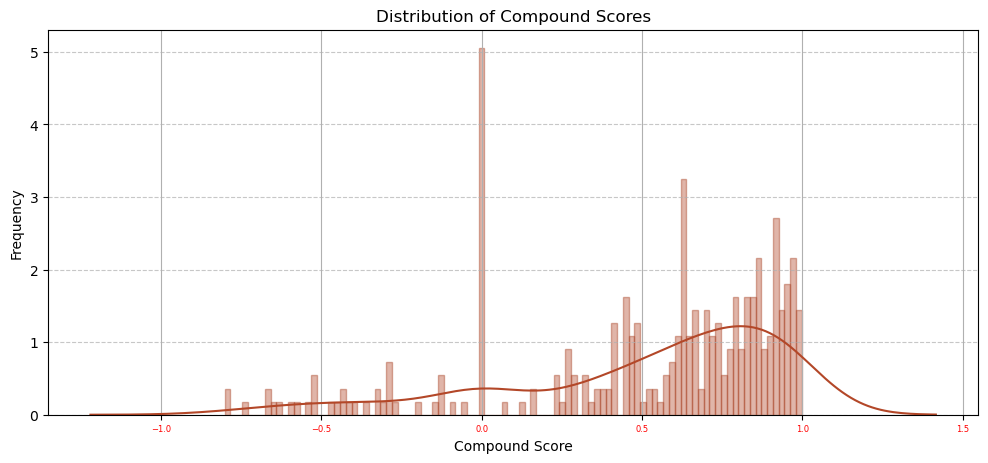

In [51]:
# Distribution of polarities using a histogram
plt.figure(figsize=(12, 5))
# sns.histplot(df['tb_polarity'], bins=400, kde=False, color='#45b397', linestyle='--')
sns.distplot(df['compound_score'], bins=100, color='#b34728', hist_kws={'edgecolor': '#a33718'})
plt.title('Distribution of Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
# plt.xticks(ticks=[10], labels=['1'], fontname='Arial', fontsize=6)
plt.tick_params(axis='x', labelsize=6, labelcolor='red')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

In [52]:
df.head()

,Rating,Title,Review,Lemmatized_Review_Text,Review_Length,Review_Without_Stopwords,Review_Length_Without_Stopwords,tb_polarity,sentiment_score_tb,sentiment_tb,compound_score,sentiment_vader
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc...",excellent workhorse durable hiperformance comp...,8,"Excellent Workhorse Durable, Hi-Performance, C...",7,1.000000,5.000000,V. Positive,0.7003,Positive
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!,awesome dependable,4,Awesome dependable laptop!,3,1.000000,5.000000,V. Positive,0.6588,Positive
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...,super light efficient crisp clean easier handl...,20,Super light efficient Crisp clean easier handl...,11,0.322000,1.610000,Positive,0.9042,V. Positive
3,5,NEW laptop is great,so far I am loving the new look and the feel o...,far loving new look feel new,15,far loving new look feel new,6,0.243182,1.215909,Positive,0.6326,Positive
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...,great build quality excellent good option qual...,36,Great build quality excellent good options. qu...,18,0.626250,3.131250,Positive,0.9764,V. Positive


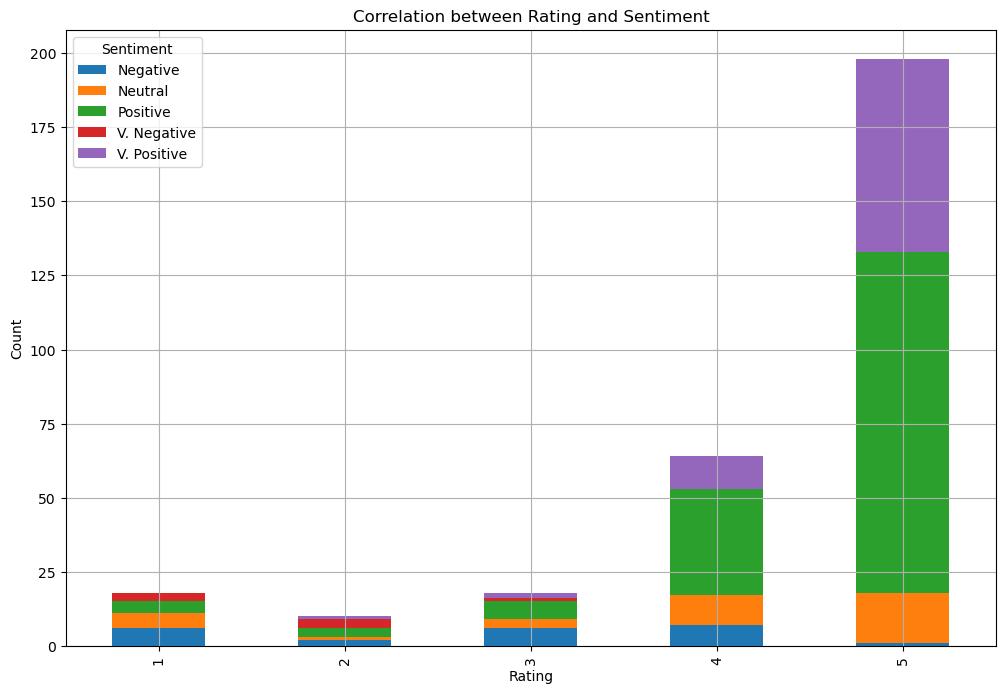

In [53]:
# Group by 'Rating' and 'Sentiment' and count occurrences
grouped_data = df.groupby(['Rating', 'sentiment_vader']).size().unstack()

# Plotting the grouped bar chart
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Correlation between Rating and Sentiment')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

## <font color='b35678'> <b> Comparing polarity vs compound score </b> </font>

In [ ]:
df1 = df[['tb_polarity','compound_score']].copy()
print(id(df1), id(df))
df1.head()

In [ ]:
scaler = MinMaxScaler()
df1=pd.DataFrame(scaler.fit_transform(df1), columns=['tb_polarity','compound_score'])
df1.head()

In [ ]:
df1['average_score'] = (df1['tb_polarity']+ df1['compound_score'])/2
df1.head()

In [ ]:
# Sort the DataFrame by 'compound_score' in ascending order
df1.sort_values(by='compound_score', inplace=True)

# Reset the index of the DataFrame
df1.reset_index(inplace=True)

# Set the figure size before plotting
plt.clf()
plt.figure(figsize=(15, 4))

# Plot 'tb_polarity' and 'compound_score' lines on the same chart
sns.lineplot(x=df1.index, y=df1['tb_polarity'], data=df1, label='tb_polarity')
sns.lineplot(x=df1.index, y=df1['compound_score'], data=df1, label='compound_score')
sns.lineplot(x=df1.index, y=df1['average_score'], data=df1, label='average_score')

# Customize the x-axis labels to show only in increments of 40
plt.xticks(range(0, len(df1), 40))  # Adjust the increment as needed

# Display the plot
plt.grid()
plt.legend()
plt.show()

## <font color='#b35678'> <b> Sentiment Correlation Analysis </b> </font>

### <font color='d37698'> <b> Normalize User Ratings </b> </font>

In [54]:
# user_ratings = df['Rating']
# normalized_ratings = [(rating - min(user_ratings)) / (max(user_ratings) - min(user_ratings)) * 2 - 1 for rating in user_ratings]

scaler = MinMaxScaler()

df['normalized_rating'] = scaler.fit_transform(df[['Rating']])

### <font color='d37698'> <b> Correlation Analysis </b> </font>

In [55]:
compound_scores = df['compound_score']
normalized_ratings = df['normalized_rating']
correlation_coefficient, p_value = pearsonr(compound_scores, normalized_ratings)

print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Pearson Correlation Coefficient: 0.5380254421032359
P-value: 1.6462963902010217e-24


### <font color='d37698'> <b> Visualization of Correlation </b> </font>

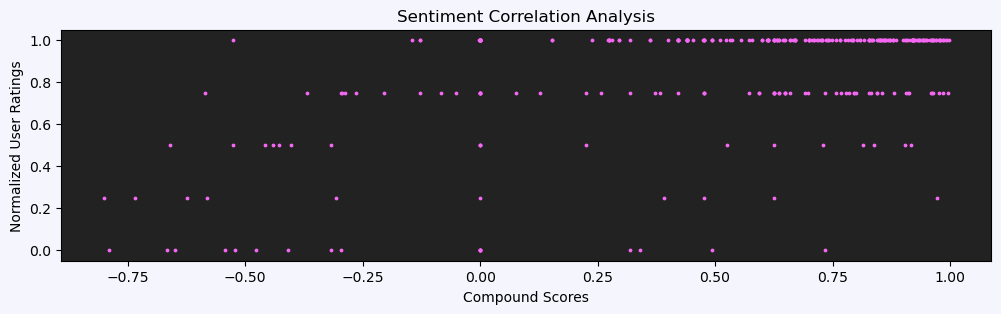

In [56]:
plt.figure(figsize=(12,3))
plt.gcf().set_facecolor('#f5f5fe')
plt.scatter(compound_scores, normalized_ratings, s=3, c='#f467f3').axes.set_facecolor('#222222')
plt.xlabel('Compound Scores')
plt.ylabel('Normalized User Ratings')
plt.title('Sentiment Correlation Analysis')
plt.show()

## <font color='b35678'> <b> Emotion Mining (using Textblob) </b> </font>

##### <font color='#938688'> <i> Using the deep copy of the original dataframe for Emotion Mining calculations </i> </font>

In [57]:
df_em = df_orig

In [58]:
df_em.head()

,Rating,Title,Review
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc..."
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...
3,5,NEW laptop is great,so far I am loving the new look and the feel o...
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...


##### <font color='#938688'> <i> Populating 'polarity' and 'subjectivity' </i> </font>

In [59]:
df_em['polarity'] = df['Review'].apply(get_polarity)
df_em['subjectivity'] = df['Review'].apply(get_subjectivity)
df_em.head()

,Rating,Title,Review,polarity,subjectivity
0,5,Very Nice,"Excellent Workhorse ... Durable, Hi-Performanc...",1.000000,1.000000
1,5,Awesome & dependable laptop!,Awesome & dependable laptop!,1.000000,1.000000
2,5,Super light and efficient laptop,Super light and efficient laptop. Crisp & clea...,0.322000,0.652667
3,5,NEW laptop is great,so far I am loving the new look and the feel o...,0.243182,0.714773
4,5,Lightweight powerhouse.,Great build quality excellent screen very goo...,0.626250,0.729792


### <font color='d37698'> <b> Plotting scatter distribution of subjectivity vs polarity </b> </fong>

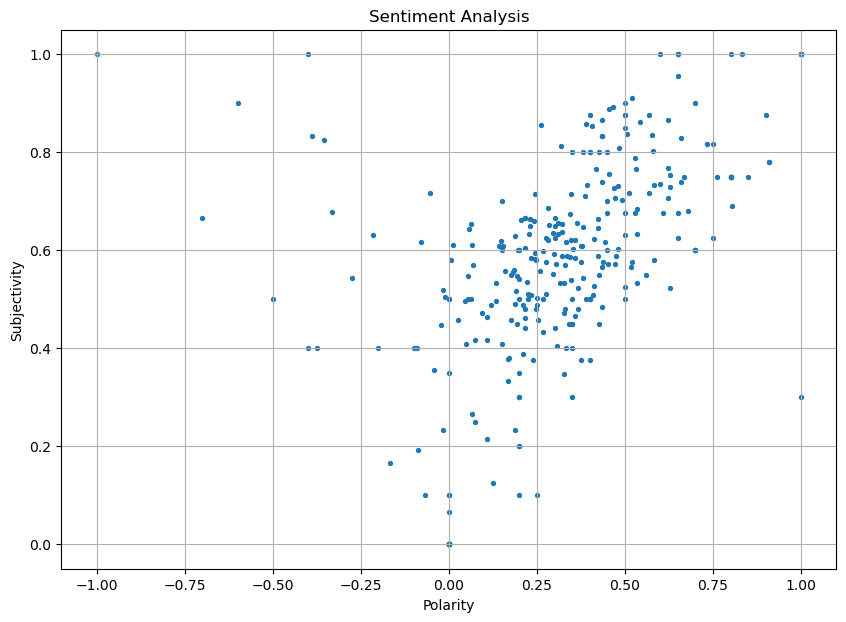

In [60]:
f, axes = plt.subplots(figsize = (10,7))
plt.scatter(df_em.polarity, df_em.subjectivity, s=8)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity');
plt.grid(True)

### <font color='d37698'> <b> Emotion Plot </b> </fong>

##### <font color='#938688'> <i> This indicates how much of emotion (subjectivity) is involved when a review is given. This has been calculated as emotional bias which is the product of polarity and subjectivity. </i> </font>

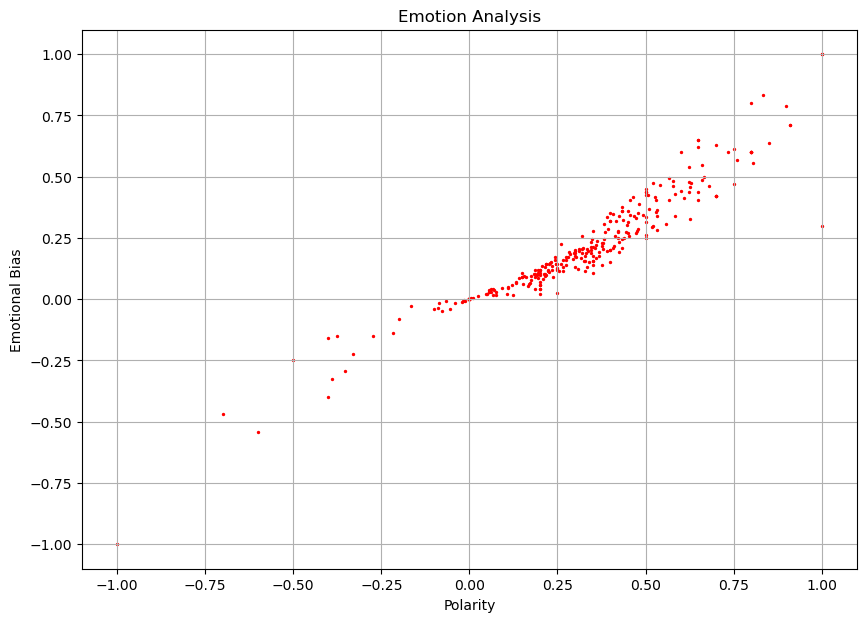

In [61]:
f, axes = plt.subplots(figsize = (10,7))
plt.scatter(df_em.polarity, df_em.subjectivity*df_em.polarity, s=2, c='red')
plt.title('Emotion Analysis')
plt.xlabel('Polarity');
plt.ylabel('Emotional Bias')
plt.grid(True)

## <font color='b35678'> <b> ML Classification Models </b> </font>

##### <font color='#938688'> <i> For ML modeling, we will use the review text and Vader sentiment that we have assigned above. </i> </font>

In [62]:
df_ml = df[['Review','sentiment_vader']]
df_ml.head()

,Review,sentiment_vader
0,"Excellent Workhorse ... Durable, Hi-Performanc...",Positive
1,Awesome & dependable laptop!,Positive
2,Super light and efficient laptop. Crisp & clea...,V. Positive
3,so far I am loving the new look and the feel o...,Positive
4,Great build quality excellent screen very goo...,V. Positive


### <font color='d37698'> <b> Splitting the data into features (X) and labels (y) </b> </fong>

In [63]:
X = df_ml['Review']
y = df_ml['sentiment_vader']
X.shape, y.shape

((308,), (308,))

### <font color='d37698'> <b> Vectorizing text data </b> </fong>

In [64]:
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

### <font color='d37698'> <b> Splitting the data into training and testing sets </b> </fong>

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

### <font color='d37698'> <b> <span style="text-decoration: underline;">Naïve Bayes (NB) Model:</span> Training, Testing and Metrics </b> </fong>

In [66]:
# Training the Naïve Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predicting on the test set and calculating accuracy
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print('Accuracy of Naïve Bayes model:', accuracy_nb)

Accuracy of Naïve Bayes model: 0.5645161290322581


### <font color='d37698'> <b> <span style="text-decoration: underline;">Support Vector Machines (SVM) Model:</span> Training, Testing and Metrics </b> </fong>

In [67]:
# Training the SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predicting on the test set and calculating accuracy
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('Accuracy of Support Vector Machines model:', accuracy_svm)

Accuracy of Support Vector Machines model: 0.5806451612903226


### <font color='d37698'> <b> <span style="text-decoration: underline;">Logistic Regression (LR) Model:</span> - Training, Testing and Metrics </b> </fong>

In [68]:
# Training the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predicting on the test set and calculating accuracy
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print('Accuracy of Logistic Regression model:', accuracy_lr)

Accuracy of Logistic Regression model: 0.5967741935483871
